In [1]:
import geopandas as gpd
import pandas as pd
%pylab inline
from shapely.wkt import loads
import os
import mplleaflet as mpll
import rasterio
import seaborn as sns
import folium 
import osmnx as ox

Populating the interactive namespace from numpy and matplotlib


## Disaster maps 2
This notebook aims to read in disaster maps data (especially population by tile and by admin unit), and visualize which areas had the highest displacement. Also show what the pattern of displacement over time was.

In [2]:
# list of the pop-by-admin-unit CSVs
admin_region_files = os.listdir('admin_regions')
admin_region_files.sort()
admin_region_files

['20190806_0000.csv',
 '20190806_0800.csv',
 '20190806_1600.csv',
 '20190807_0000.csv',
 '20190807_0800.csv',
 '20190807_1600.csv',
 '20190808_0000.csv',
 '20190808_0800.csv',
 '20190808_1600.csv',
 '20190809_0000.csv',
 '20190809_0800.csv',
 '20190809_1600.csv',
 '20190810_0000.csv',
 '20190810_0800.csv',
 '20190810_1600.csv',
 '20190811_0000.csv',
 '20190811_0800.csv',
 '20190811_1600.csv',
 '20190812_0000.csv',
 '20190812_0800.csv',
 '20190812_1600.csv',
 '20190813_0000.csv',
 '20190813_0800.csv',
 '20190813_1600.csv',
 '20190814_0000.csv',
 '20190814_0800.csv',
 '20190814_1600.csv',
 '20190815_0000.csv',
 '20190815_0800.csv',
 '20190815_1600.csv',
 '20190816_0000.csv',
 '20190816_0800.csv',
 '20190816_1600.csv',
 '20190817_0000.csv',
 '20190817_0800.csv',
 '20190817_1600.csv']

In [3]:
admin_region_files[:3]

['20190806_0000.csv', '20190806_0800.csv', '20190806_1600.csv']

In [4]:
# load one in, preview it
df1 = pd.read_csv('admin_regions/'+admin_region_files[9], names = ['z_score','baseline_people','crisis_people','difference','percent_change','region_name','spaco_id','geometry'], skiprows=1)
df1['baseline_people'] = [int(foo) for foo in df1.baseline_people]
df1['geometry'] = df1['geometry'].apply(loads)
gdf = gpd.GeoDataFrame(df1, geometry = 'geometry')

In [5]:
df2 = pd.DataFrame(df1.set_index('region_name')[['baseline_people','crisis_people','percent_change','z_score']].sort_values('baseline_people', ascending = False).head(5))
#region_names = df1.region_name.unique()

In [9]:
gdf.head()

,z_score,baseline_people,crisis_people,difference,percent_change,region_name,spaco_id,geometry
0,-1.753273,244,218,-26.666667,-10.854817,Sangole,1103060,"(POLYGON ((75.335728 17.259585, 75.33304799999..."
1,-0.980321,170,90,-80.583333,-46.964546,Patan,1103073,"POLYGON ((74.067683 17.318493, 74.067238 17.32..."
2,-0.455529,1237,1180,-57.083333,-4.610621,Karad,1103074,"POLYGON ((74.293708 17.315555, 74.293221 17.31..."
3,-1.208276,72,31,-41.273879,-56.328230,Vaibhavvadi,1103085,"POLYGON ((73.88607499999999 16.454027, 73.8854..."
4,-1.209484,251,157,-94.666667,-37.467018,Kankavli,1103086,"POLYGON ((73.954487 16.208303, 73.947977999999..."


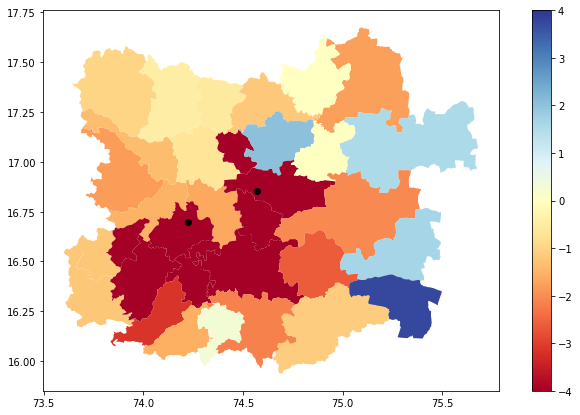

In [8]:
gdf.plot(column = 'z_score',legend = True, vmin=-4, vmax =4, cmap = 'RdYlBu',figsize = [12,7])
plt.scatter(74.223182,16.698363, color = 'k')   # Kohlapur
plt.scatter(74.569727,16.851446, color = 'k')    # Sangli

In [ ]:
ox.gdf_from_place('Sangli, India')

In [ ]:
MH_districts = gpd.read_file('data/maharashtra_shp/maharashtra.shp')
MH_districts[(MH_districts.NAME_2 == 'Sangli') | (MH_districts.NAME_2 == 'Kolhapur')].to_json()
MH_districts.head(3)

In [8]:
def generateBaseMap(default_location=[16.8502534,74.5948885], default_zoom_start=9):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

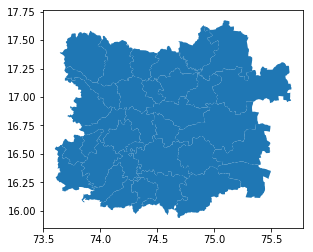

In [50]:
gdf.crs = {'init' :'epsg:4326'}
gdf.plot()

In [51]:
from branca.colormap import linear

colormap = linear.RdYlBu_07.scale(-4,4)

colormap

In [52]:
gdf_dict = gdf.set_index('region_name')['z_score']

In [53]:
gdf.head(1)

,z_score,baseline_people,crisis_people,difference,percent_change,region_name,spaco_id,geometry
0,-1.753273,244,218,-26.666667,-10.854817,Sangole,1103060,"(POLYGON ((75.335728 17.259585, 75.33304799999..."


In [54]:
from folium import plugins

In [55]:
m = generateBaseMap()
folium.Choropleth(geo_data = gdf, data = gdf,
                  columns = ['region_name','z_score'],
                  key_on='feature.properties.region_name',
                      legend_name='Difference from baseline population level (z-score)',
                  highlight=True,
                  name = 'population',
                  fill_color='YlOrRd').add_to(m)
folium.LayerControl(collapsed=False).add_to(m)
minimap = plugins.MiniMap()
m.add_child(minimap)

m

In [14]:
m.save(os.path.join('results', 'admin_units1.html'))


In [15]:
my_json['features']

NameError: name 'my_json' is not defined

In [16]:
m = generateBaseMap()

folium.GeoJson(
    gdf.to_json(),
    style_function=lambda feature : {
    'fillColor': colormap(gdf_dict[feature['region_name']]),
    'color': 'black'}
    ).add_to(m)

#folium.LayerControl().add_to(m)
m

KeyError: 'region_name'

In [277]:
names = MH_districts[(MH_districts.NAME_2 == 'Sangli') | (MH_districts.NAME_2 == 'Kolhapur')].NAME_3.to_list()

In [278]:
m

In [252]:
folium.Marker([74.569727,16.851446]).add_to(m)

In [261]:
m = generateBaseMap()
folium.Marker([16.851446,74.569727], popup='<i>Sangli</i>',tooltip = 'Sangli').add_to(m)
m

In [137]:
# function to make time series DF for chosen admin unit

def make_TS_by_admin_unit(admin_unit = 'Sangole', pth = 'admin_regions/', FNs = admin_region_files):
    new_df = pd.DataFrame(columns = ['z_score','baseline_people',
                'crisis_people','difference','percent_change','region_name','spaco_id','geometry','date'])
    for FN in FNs:
        tmp_df = pd.read_csv(pth+FN, names = ['z_score','baseline_people','crisis_people','difference','percent_change','region_name','spaco_id','geometry'], skiprows=1)
        tmp_df['date'] = FN[:-4]
        new_df = new_df.append(tmp_df[tmp_df.region_name == admin_unit])
    new_df.reset_index(inplace = True)
    
    new_df.date = ['{}/{}/{}/{}'.format(d[0:4],d[4:6],d[6:8],d[9:11]) for d in new_df.date]
    new_df.date = pd.to_datetime(new_df.date, format='%Y/%m/%d/%H')
    new_df.set_index(new_df.date, inplace=True)
    
    new_df['z_score_rolling'] = new_df.z_score.rolling(3).mean()
    
    return(new_df)

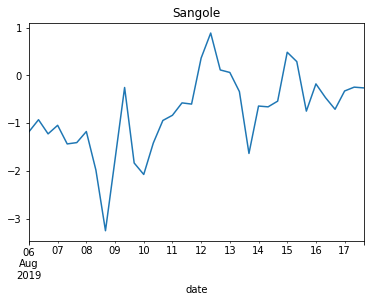

In [121]:
df = make_TS_by_admin_unit()
df.z_score.plot(title = 'Sangole')

In [132]:
df['z_score_rolling'] = df.z_score.rolling(4).mean()

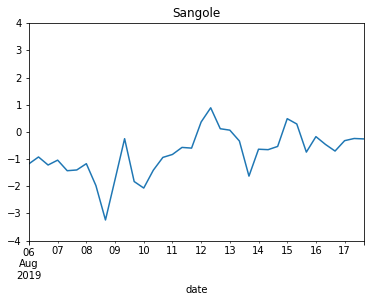

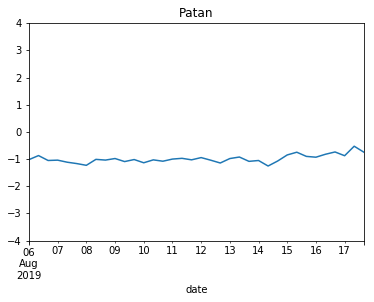

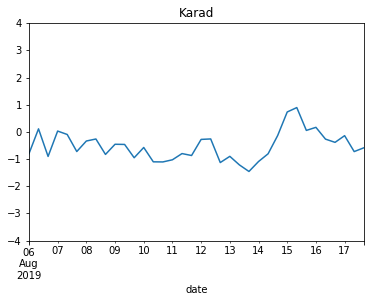

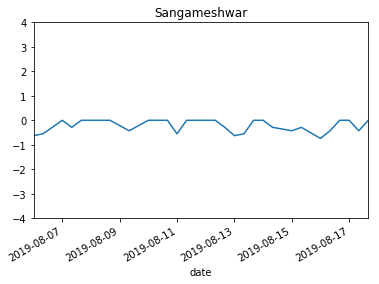

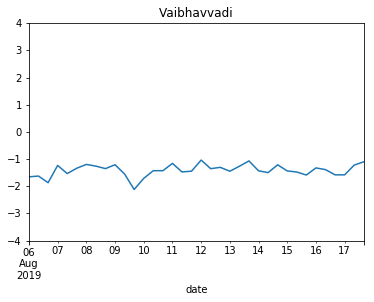

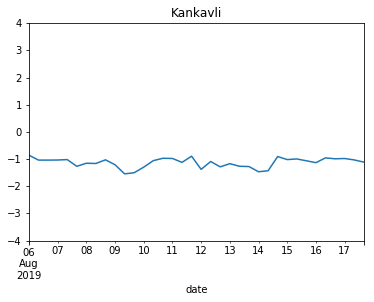

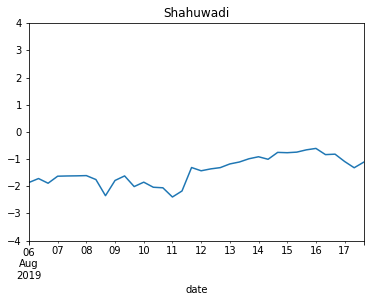

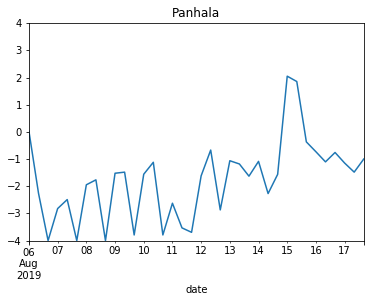

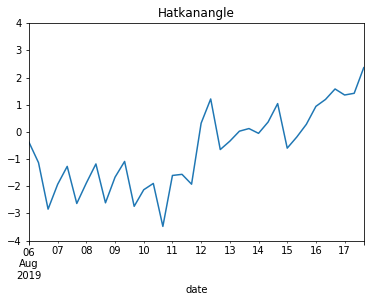

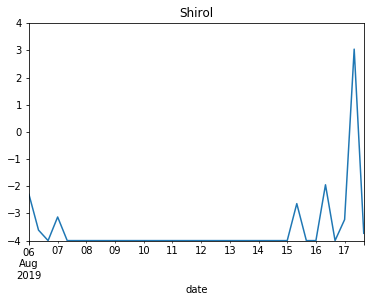

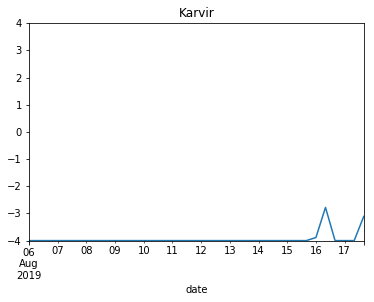

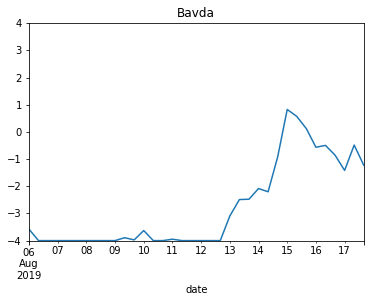

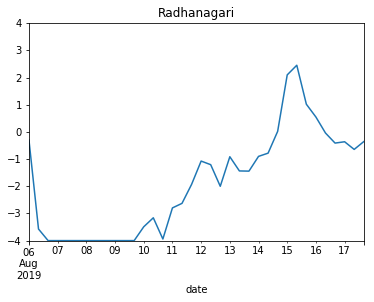

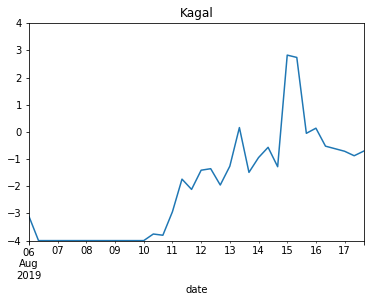

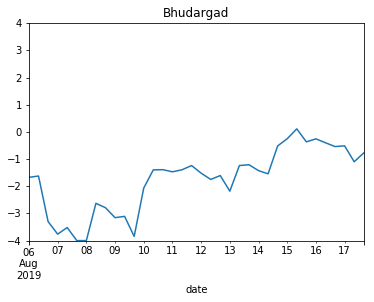

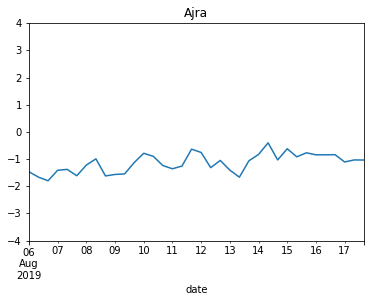

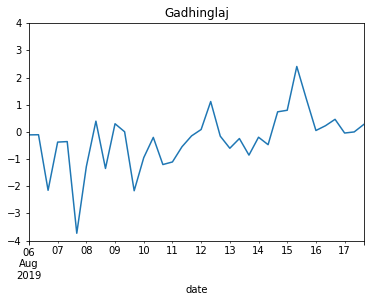

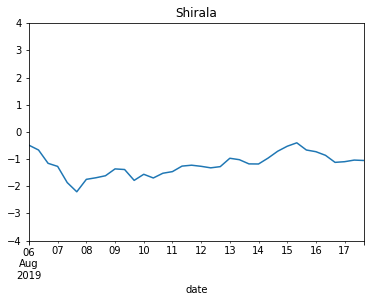

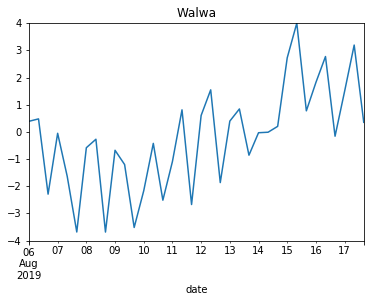

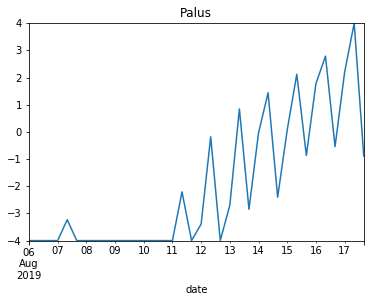

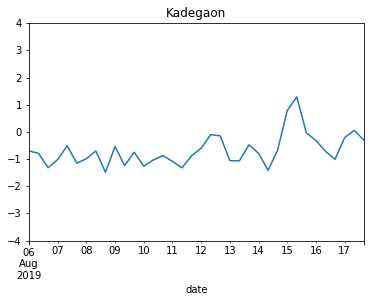

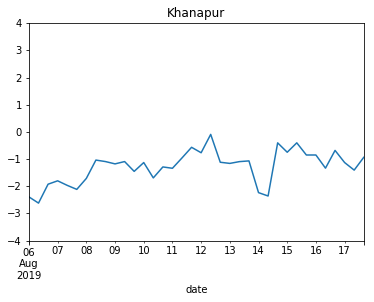

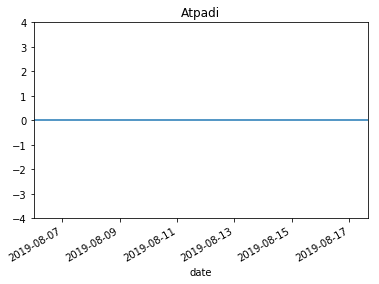

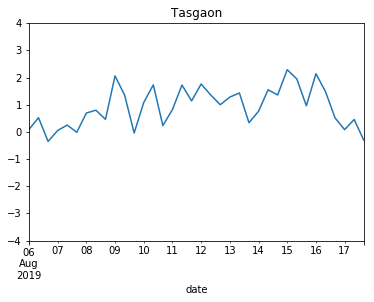

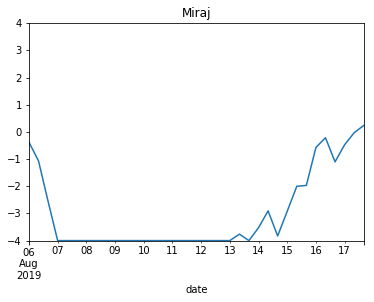

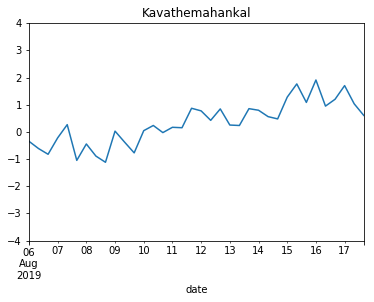

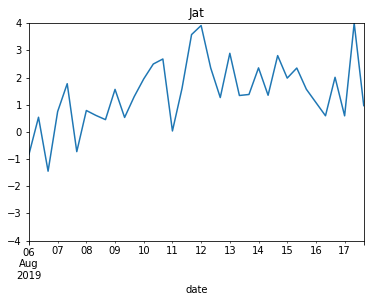

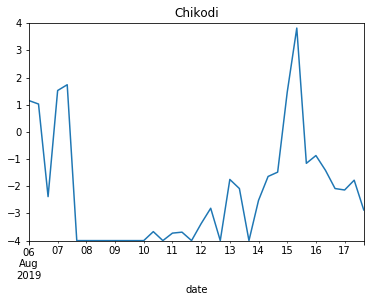

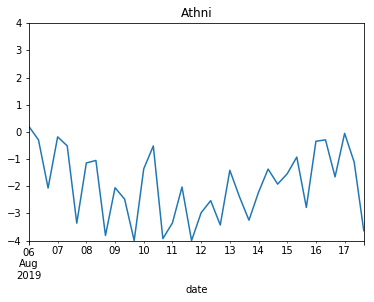

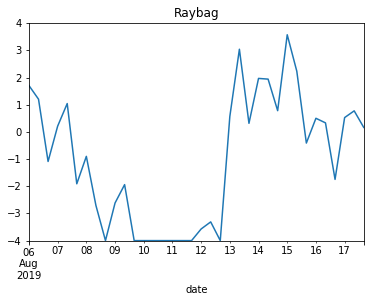

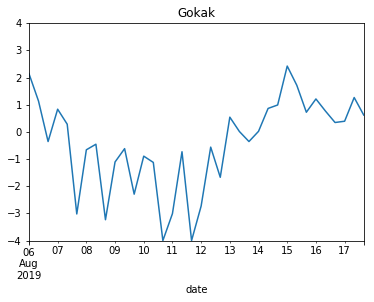

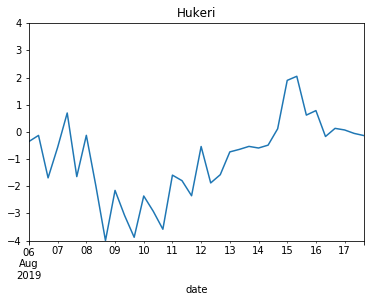

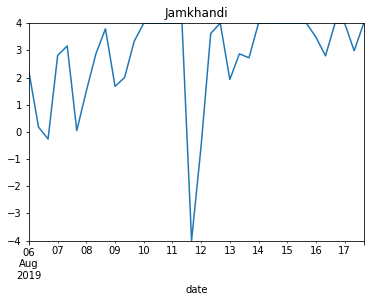

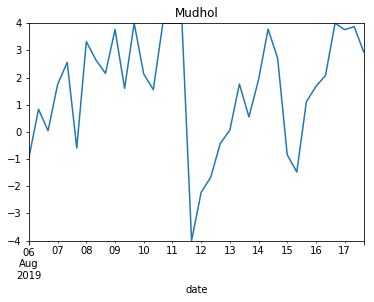

In [138]:
for i in region_names:
    make_TS_by_admin_unit(i).z_score.plot(title = i,ylim = [-4,4])
    plt.show()

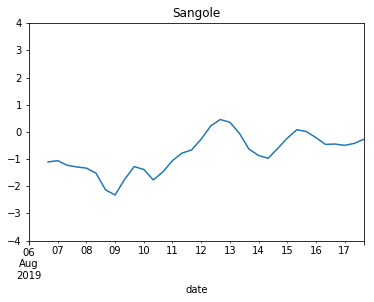

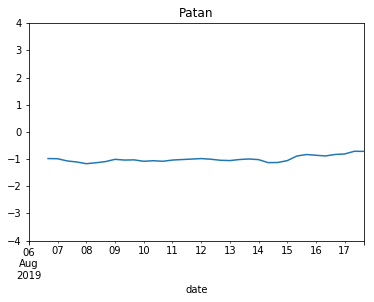

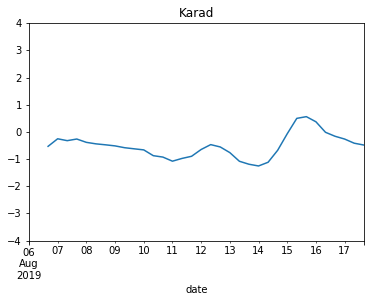

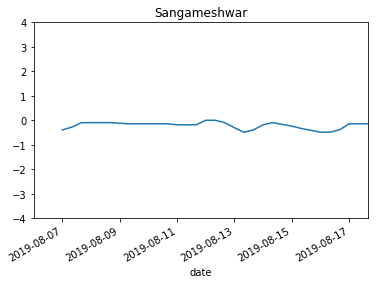

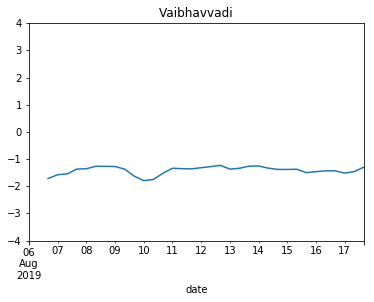

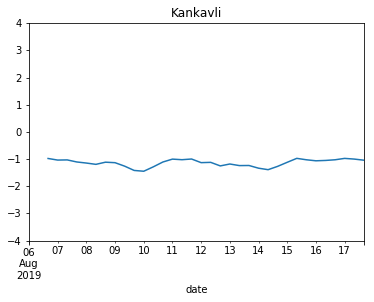

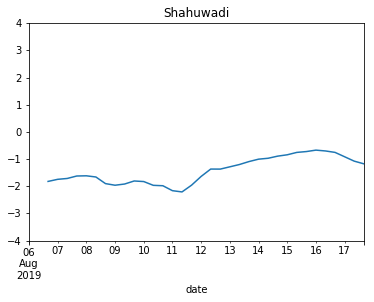

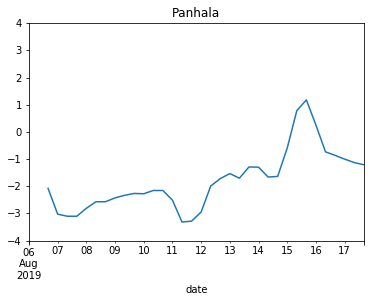

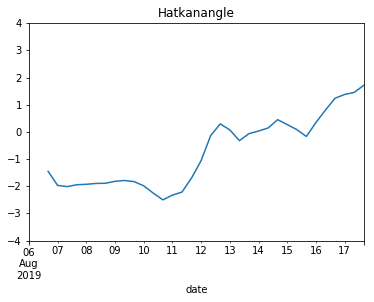

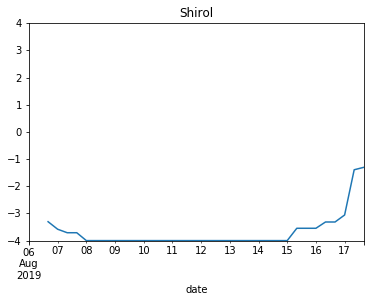

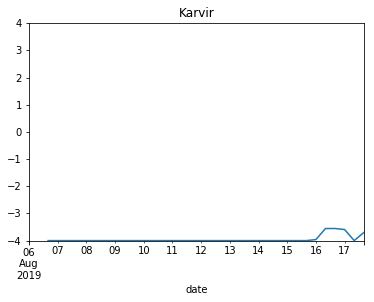

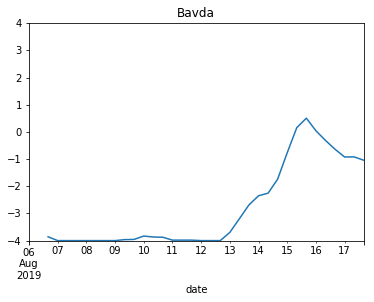

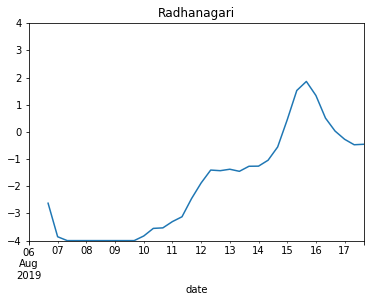

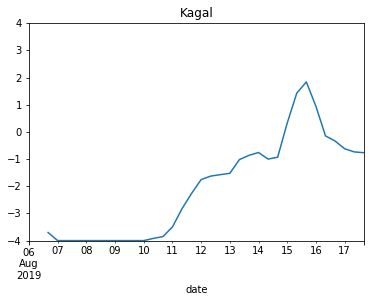

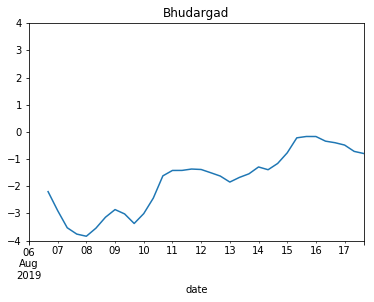

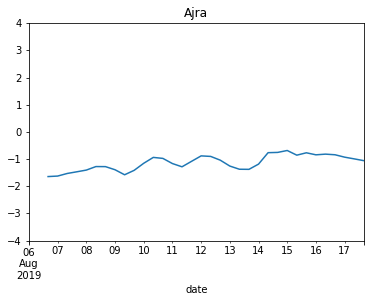

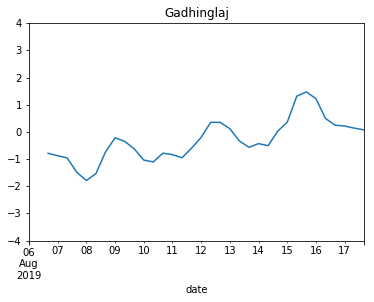

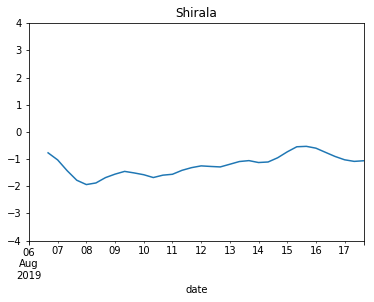

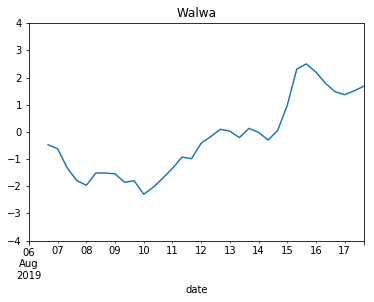

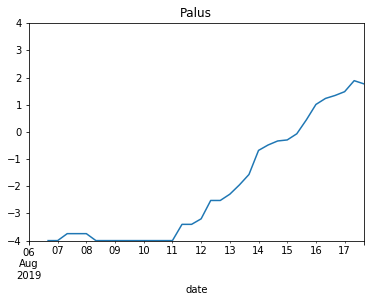

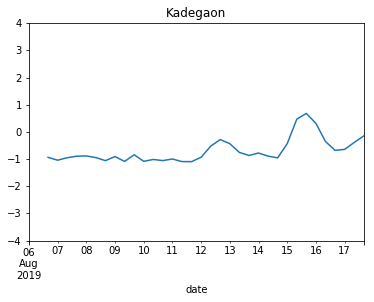

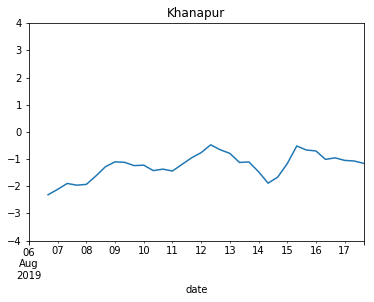

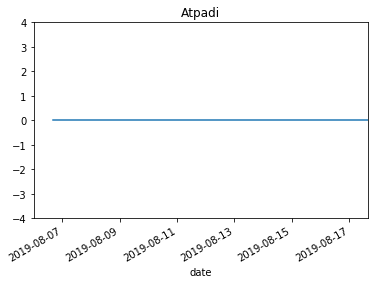

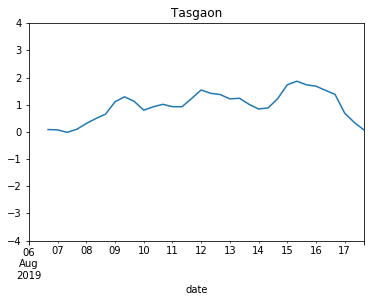

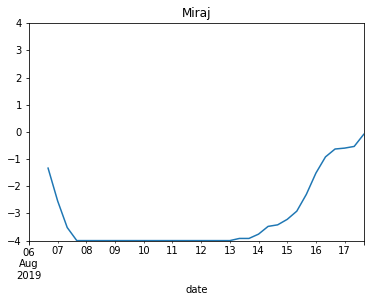

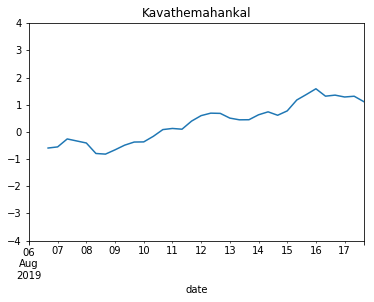

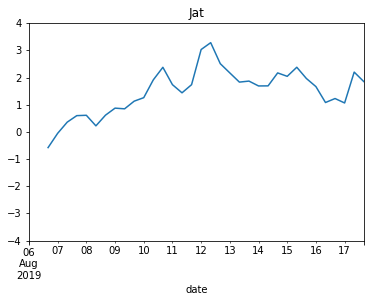

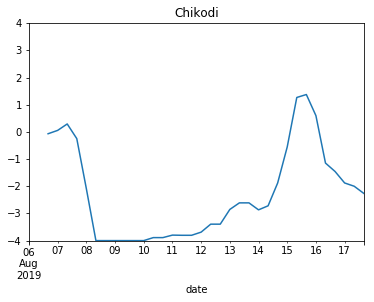

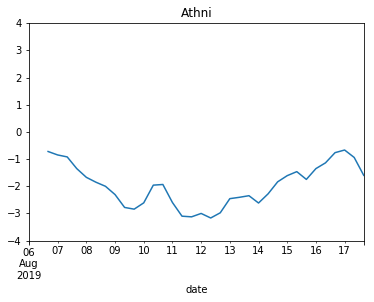

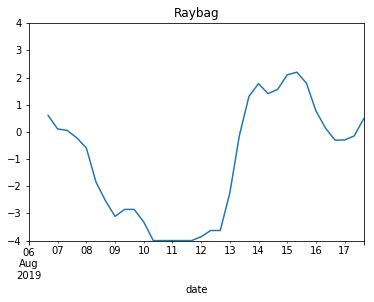

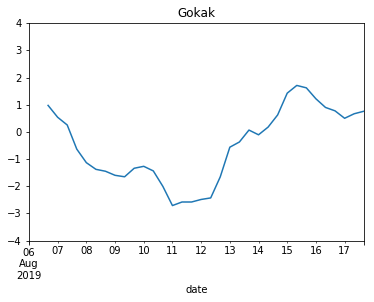

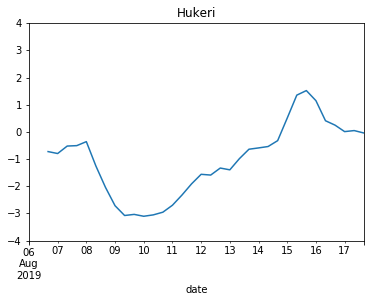

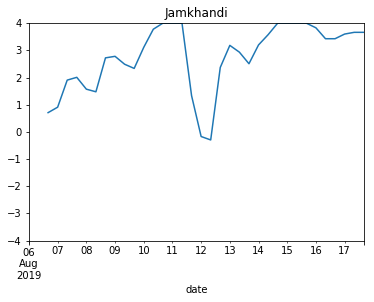

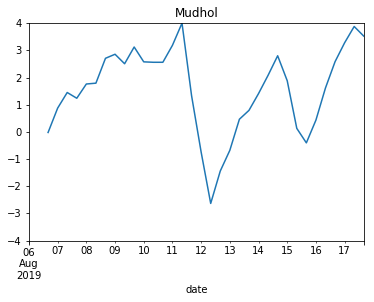

In [139]:
for i in region_names:
    make_TS_by_admin_unit(i).z_score_rolling.plot(title = i,ylim = [-4,4])
    plt.show()

In [83]:
sample = pd.Series(np.random.randn(100000)) 

In [84]:
sample.describe()

count    100000.000000
mean         -0.001011
std           0.999564
min          -4.532317
25%          -0.675529
50%          -0.004802
75%           0.673538
max           4.375102
dtype: float64

Text(0.5, 1.0, 'Standard normal distribution')

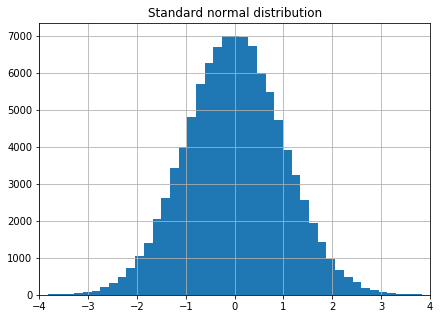

In [95]:
sample.hist(bins = 50,figsize = [7,5])
plt.xlim([-4,4])
plt.title('Standard normal distribution')

In [99]:
sample.hist(bins = 50,figsize = [7,5])
plt.xlim([-4,4])
plt.title('Standard normal distribution')

0        5022.600934
1        4975.517094
2        4962.805355
3        5017.165216
4        4989.234118
5        5060.238809
6        5051.141680
7        5007.391802
8        4940.756083
9        4986.346545
10       5079.818013
11       4937.258451
12       5098.360912
13       5073.006175
14       4917.944941
15       4937.111301
16       4985.891372
17       4951.561982
18       4999.605852
19       4866.133811
20       4958.726151
21       4990.271554
22       5068.394936
23       4992.578129
24       4931.236238
25       5010.456671
26       5071.232800
27       4955.044659
28       5009.484467
29       4931.860960
            ...     
99970    4958.782525
99971    5012.620262
99972    5036.631921
99973    5033.657013
99974    4984.293778
99975    5025.694651
99976    4994.862940
99977    4966.623566
99978    4969.581753
99979    5014.866894
99980    4963.277812
99981    5009.435585
99982    4934.628172
99983    4975.425173
99984    5052.622867
99985    4975.678573
99986    5010